# Quantile Regression Benchmarks

We benchmark multiple implementations for the quantile regression process. 

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import itertools
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from tqdm import tqdm

import pyfixest as pf

warnings.filterwarnings("ignore")


def generate_data(N: int, k: int) -> pd.DataFrame:
    """Simulate t‑distributed noise linear model."""
    X = np.random.randn(N, k)
    beta = np.random.randn(k)
    y = X @ beta + np.random.normal(0, 1, N)
    data = pd.DataFrame(X, columns=[f"X{i + 1}" for i in range(k)])
    data["Y"] = y
    data["id"] = np.arange(N)
    return data

In [2]:
def visualize_benchmarks(df):
    """
    Visualize benchmark timings by N, with separate panels for each k,
    arranged horizontally. All estimates are averages of three iterations.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns: 'N', 'k', 'method', 'seconds'
    """
    unique_ks = sorted(df["k"].unique())
    num_panels = len(unique_ks)

    fig, axes = plt.subplots(1, num_panels, figsize=(5 * num_panels, 5), sharey=True)

    if num_panels == 1:
        axes = [axes]  # ensure iterable

    for ax, k_val in zip(axes, unique_ks):
        subset = df[df["k"] == k_val]
        for method, group in subset.groupby("method"):
            grp = group.sort_values("N")
            ax.plot(grp["N"], grp["seconds"], marker="o", label=method, linewidth=2)
        ax.set_title(f"k = {k_val}", fontsize=13, fontweight="bold")
        ax.set_xlabel("Sample Size (N)", fontsize=11)
        ax.set_xlim(df["N"].min(), df["N"].max())
        ax.set_yscale("log")
        ax.grid(True, linestyle="--", alpha=0.7)

    axes[0].set_ylabel("Avg. Time (seconds)", fontsize=11)

    # Add legend outside the last plot
    axes[-1].legend(title="Method", loc="upper left", bbox_to_anchor=(1.05, 1))

    fig.suptitle(
        "Benchmark Timing of the Quantile Regression Process with 10 Quantiles by N and k (Average of 3 Runs)",
        fontsize=15,
        fontweight="semibold",
    )

    plt.tight_layout(rect=[0, 0, 0.92, 0.95])  # leave space for title + legend
    plt.show()
    plt.savefig("quantreg_benchmarks.png")

In [3]:
def run_quant_benchmark(
    Ns,
    ks,
    quantile_sets,
    vcov="iid",
    method="cfm1_fn",
    reps_small=3,
    reps_large=1,
    seed=231,
):
    """
    Run timing benchmarks for different quantreg methods.

    Parameters
    ----------
    Ns : iterable of int
    ks : iterable of int
    quantile_sets : dict[str, list[float]]
    vcov : str
    method : str
        One of "loop_pfn", "loop_fn", "sm_loop",
        "cfm1_pfn", "cfm2_pfn", "cfm1_fn", "cfm2_fn".
    reps_small : int
    reps_large : int
    seed : int
    """
    records = []
    for N, k, Q in tqdm(itertools.product(Ns, ks, quantile_sets.keys())):
        # reps = reps_small if N < 100_000 else reps_large
        reps = 3
        data = generate_data(N, k)
        fml = "Y ~ " + " + ".join(f"X{i + 1}" for i in range(k))
        quantiles = quantile_sets[Q]

        def _timeit(fn):
            t0 = time.time()
            for _ in range(reps):
                fn()
            return (time.time() - t0) / reps

        if method == "loop_pfn":
            secs = _timeit(
                lambda: [
                    pf.quantreg(fml, data=data, quantile=q, method="pfn", vcov=vcov)
                    for q in quantiles
                ]
            )

        elif method == "loop_fn":
            secs = _timeit(
                lambda: [
                    pf.quantreg(fml, data=data, quantile=q, method="fn", vcov=vcov)
                    for q in quantiles
                ]
            )

        elif method == "sm_loop":
            secs = _timeit(
                lambda: [smf.quantreg(fml, data=data).fit(q=q) for q in quantiles]
            )

        elif method in ("cfm1_pfn", "cfm2_pfn", "cfm1_fn", "cfm2_fn"):
            multi_method, base_method = method.split("_")
            # multi_method is "cfm1" or "cfm2"
            # base_method is "pfn" or "fn"
            secs = _timeit(
                lambda: pf.quantreg(
                    fml=fml,
                    method=base_method,
                    multi_method=multi_method,
                    seed=seed,
                    quantile=quantiles,
                    data=data,
                    vcov=vcov,
                )
            )

        else:
            raise ValueError(f"Unknown method: {method!r}")

        records.append(
            {
                "N": N,
                "k": k,
                "Q": Q,
                "method": method,
                "seconds": secs,
                "reps": reps,
                "n_quantiles": len(quantiles),
            }
        )

    records = pd.DataFrame(records)
    records.to_csv(
        f"data/quantreg/quant_benchmark_{method}_{N}_{k}_{len(quantiles)}.csv",
        index=False,
    )
    return records

In [18]:
np.random.seed(991)

Ns = [1_000_000]
ks = [5, 20]

quantile_sets = {
    10: np.linspace(0.05, 0.95, 10).tolist(),
}

In [ ]:
for method in tqdm(
    [
        "cfm1_fn",
        "cfm2_fn",
        # "loop_pfn", "loop_fn",
        "sm_loop",
        "cfm1_pfn",
        "cfm2_pfn",
    ]
):
    print(f"Running benchmark for method: {method}")
    for N in Ns:
        for k in ks:
            print(f"Running for N={N}, k={k}")
            run_quant_benchmark(
                Ns=[N],
                ks=[k],
                quantile_sets=quantile_sets,
                vcov="iid",
                method=method,
                seed=1231231,
            )

In [4]:
all_benchmarks = pd.concat(
    [pd.read_csv(f) for f in glob.glob("data/quantreg/*.csv")], ignore_index=True
).sort_values(["N", "k", "Q", "method"])

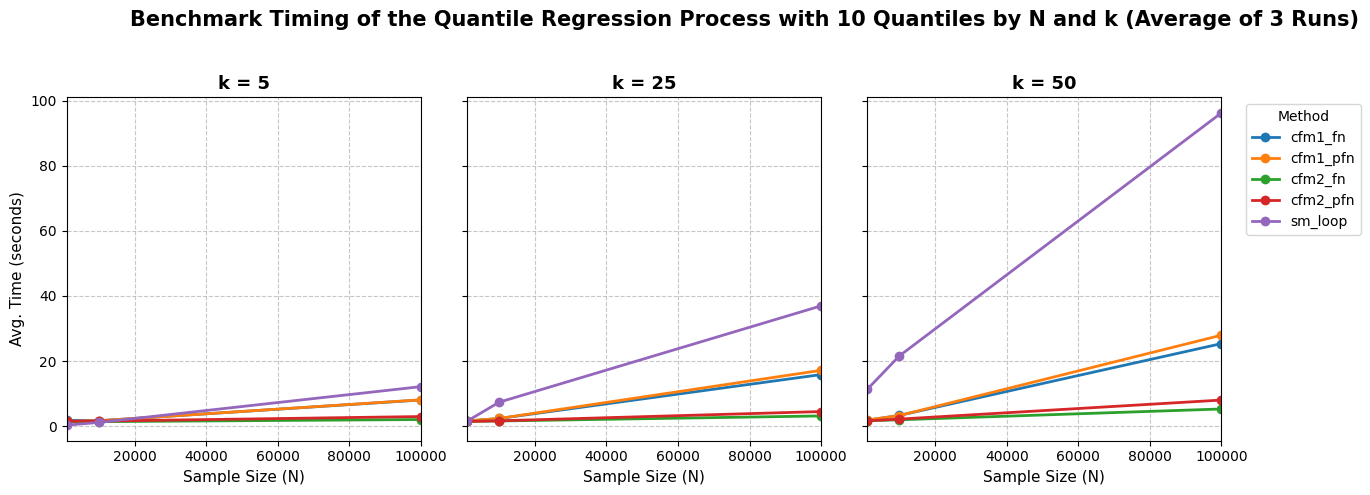

<Figure size 640x480 with 0 Axes>

In [5]:
visualize_benchmarks(all_benchmarks)